<h1>TD3 : Let's play with faces</h1>  
Part 2 - Celebrity look alike(find celebrity)

S. Delprat, INSA Hauts-de-France    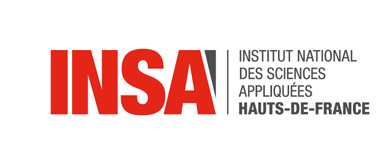


In [30]:
# Import and install inception-resnet-v1 files
import os
import zipfile

extractFolder='../data/processed/InceptionResnetV1'
if os.path.isdir(os.path.join(extractFolder,"InceptionResnetV1"))==0:
  with zipfile.ZipFile("InceptionResnetV1.zip", 'r') as zip_ref:
    zip_ref.extractall(extractFolder)


Define the binary file that contains the embedding vector

In [31]:
binaryEmbeddingFile='../models/td3/result/Part1_Celeb/embeddingCelebrity.bin'
# Import IMDB Head dataset
extractFolder='../data/processed'
baseFolder=os.path.join(extractFolder,'IMDB_Head_Aligned')
if os.path.isdir(baseFolder)==0:
  print('Extracting the dataset')
  with zipfile.ZipFile("IMDB_Head_Aligned.zip", 'r') as zip_ref:
    zip_ref.extractall(extractFolder)

In [32]:
import torch
from PIL import Image
from torchvision.transforms import v2
from facenet_pytorch import MTCNN

Configuration of the hyperparameters

In [33]:
maxImgsCeleb    = None
batchSize       = 128
H,W             = 160,160  # image height & width
dataFolder      = baseFolder
embeddingFile   = 'embeddingCelebrity.bin'

Check cuda availability (if not available, please select GPU P100 as an accelerator and NOT the dual T4)

In [34]:
if torch.cuda.is_available():
  print('cuda is available')
  device='cuda'
  for i in range(torch.cuda.device_count()):
    print(torch.cuda.get_device_properties(i).name)

    device_cap = torch.cuda.get_device_capability()
    print('device capability : ',torch.cuda.get_device_capability())
else:
  print('cuda is not available')
  device='cpu'

cuda is available
NVIDIA GeForce GTX 1050
device capability :  (6, 1)


# 1) Load a pretrained model and prepare it for embedding extraction
Here we are going to use an Inception-Resnet-V1 model trained on the VGG Face2 dataset (the model has been generated using code from the <a href="https://github.com/timesler/facenet-pytorch">original repo</a>).  
This model requires the image to be scaled in the [-1,1] range. It is suggested to use the following transform: <code>modeltransforms=v2.Lambda(lambda x:x*2-1)</code>

The goal of this section is to load the model and replace all the layers contained in the classification head by identity.
The resulting model is denoted as backbone



*Q1.* Load the original model  
Store the model in the <code>backbone</code> variable

In [35]:
# add some code to load the model saved in "InceptionResnetV1_VGGFace2.zip'"
from facenet_pytorch import InceptionResnetV1

# Load the inception resnet vith weights trained on the VGG Face2 dataset
backbone = InceptionResnetV1(pretrained='vggface2')

*Q2.* Replace the classification head by identity layers  

From the previous list, look at all the layers name (between parenthesis) that belongs to the classification head. Overwrite them by a <code>torch.nn.Identity layer</code>.  
As a result, the network will now output the embeding vector computed by the convolution part

In [36]:
# Overwrite classification head
from torch.nn import Identity

backbone.last_linear = Identity()
backbone.last_bn = Identity()

Display the model summary and check that the classification head has been removed. Also take note of the shape of the produced data

In [37]:
# Print a summary using torchinfo (uncomment for actual output)
from torchinfo import summary
summary(model=backbone,
        input_size=(32, 3, H, W), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
InceptionResnetV1 (InceptionResnetV1)         [32, 3, 160, 160]    [32, 1792]           4,427,703            True
├─BasicConv2d (conv2d_1a)                     [32, 3, 160, 160]    [32, 32, 79, 79]     --                   True
│    └─Conv2d (conv)                          [32, 3, 160, 160]    [32, 32, 79, 79]     864                  True
│    └─BatchNorm2d (bn)                       [32, 32, 79, 79]     [32, 32, 79, 79]     64                   True
│    └─ReLU (relu)                            [32, 32, 79, 79]     [32, 32, 79, 79]     --                   --
├─BasicConv2d (conv2d_2a)                     [32, 32, 79, 79]     [32, 32, 77, 77]     --                   True
│    └─Conv2d (conv)                          [32, 32, 79, 79]     [32, 32, 77, 77]     9,216                True
│    └─BatchNorm2d (bn)                       [32, 32, 77, 77]     [32, 32, 77, 77]  

# 2) Load and process the querry image

This function load an image given its file name

In [38]:
def loadImage(fileName):
  img = Image.open(fileName)
  img2 = v2.PILToTensor()(img)
  return img2

*Q3.* Copy an image to your google drive.  
Browse to this image and copy the image path

In [39]:
queryImagePath="../data/raw/others/sample_image_elias.jpg"

*Q4.* Load and display the query image   
Store the image into a variable <code>queryImg</code>

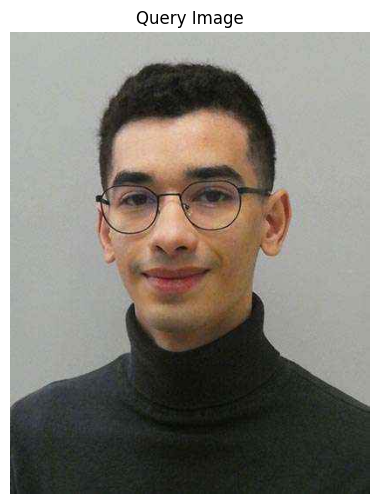

Query image shape: torch.Size([3, 531, 413])


In [40]:
import matplotlib.pyplot as plt
# Load and display the query image
queryImg = loadImage(queryImagePath)

# Display the image
plt.figure(figsize=(6, 6))
plt.imshow(queryImg.permute(1, 2, 0).numpy())
plt.title("Query Image")
plt.axis('off')
plt.show()

print(f"Query image shape: {queryImg.shape}")

*Q5.* Copy the faceCropping function from the previous exercices (age prediction)

In [41]:
myTransform = v2.Lambda(lambda x: x / 127.5 - 1.0)  # Scale data into the -1..1 range

def faceCropping(mtcnn, imgsBatch, myTransform, verbose=False):
    PILBatch = [v2.ToPILImage()(img) for img in imgsBatch]
    kept_indices = list(range(len(PILBatch)))  # Assume all are kept initially
    nLost = 0
    try:
        # Process batch at once
        faces = mtcnn(PILBatch)
        imgsBatch = torch.stack(faces)
        imgsBatch = myTransform(imgsBatch)
    except:
        # Process each image individually and track kept indices
        kept_indices = []
        imgsBatch_list = []
        for i, PILimg in enumerate(PILBatch):
            try:
                data = mtcnn(PILimg)
                data = myTransform(data)
                imgsBatch_list.append(data)
                kept_indices.append(i)
            except:
                pass
        imgsBatch = torch.stack(imgsBatch_list) if imgsBatch_list else torch.empty(0)
        nLost = len(PILBatch) - len(kept_indices)
        if verbose and nLost > 0:
            print(f'{nLost} image(s) lost')
    return imgsBatch, kept_indices, nLost

Define a mtcnn object to detect faces  

In [42]:
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=False,
    device=device
)

*Q6.* add a batch dimension to the reference image <code>queryImg</code>using <code>unsqueeze</code> in order to make the image size compatible with the existing <code>faceCropping</code> function that requires tensor with shape batch x 3 x width x height .  

In [43]:
# Add a batch dimension to make it compatible with faceCropping
queryImg_batch = queryImg.unsqueeze(0)
print(f"Query image batch shape: {queryImg_batch.shape}")

Query image batch shape: torch.Size([1, 3, 531, 413])


*Q7.* Apply the face cropping function to that batch and display the result shape

Cropped query image shape: torch.Size([1, 3, 160, 160])


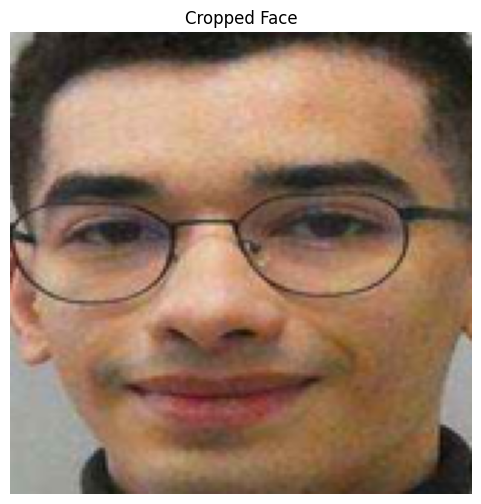

In [44]:
# Apply face cropping to the query image
croppedQueryImg, kept_indices, nLost = faceCropping(mtcnn, queryImg_batch, myTransform, verbose=True)
print(f"Cropped query image shape: {croppedQueryImg.shape}")

# Display the cropped face
if croppedQueryImg.shape[0] > 0:
    plt.figure(figsize=(6, 6))
    # Denormalize for visualization
    plt.imshow((croppedQueryImg[0].permute(1, 2, 0).numpy() + 1) * 0.5)
    plt.title("Cropped Face")
    plt.axis('off')
    plt.show()
else:
    print("No face detected in the query image!")

*Q8.* Compute the embedding vector for this batch using the backbone  
Store the embedding vector into <code>queryEmbeddingBatch</code>

In [45]:
# Move the model to the appropriate device
backbone = backbone.to(device)
backbone.eval()

# Compute embedding vector for the query image
with torch.no_grad():
    queryEmbeddingBatch = backbone(croppedQueryImg.to(device))

print(f"Query embedding shape: {queryEmbeddingBatch.shape}")

# Move the embedding to CPU for easier manipulation
queryEmbeddingBatch = queryEmbeddingBatch.cpu()

Query embedding shape: torch.Size([1, 1792])


# 3) Search for the celebrity lookalike

At this point of the program, we have a variable <code>refEmbeddingBatch</code> of size batch(1) x 1792 (embedding vect size) and you have loaded all the embedding vectors computed over the IMDB celebrity dataset.  
=> the remaining part consists in finding the most similar vectors

*Q9.* Load the embeddings & file names from the pickle  
Store the embeddings into <code>allCelebrityEmbeddings</code> and the file names into <code>allCelebrityFileNames</code>

In [46]:
import pickle
with open(binaryEmbeddingFile, 'rb') as f:
    allCelebrityEmbeddings, loaded_indices = pickle.load(f)

*Q10.* If the embedding vector were stored in a python list, convert it to a tensor using <code>torch.tensor</code>  
If you use the code from the age prediction exercise to generate the embeding, the embedding may be stored in <code>allCelebrityFileNames[0]</code> where <code>[0]</code> refers to the "train" dataset (for this exercise, there is a single dataset)

In [47]:
print(allCelebrityEmbeddings.shape)

torch.Size([2998, 1792])


*Q11.* Extract the number of celebrity vector embedding into <code>nEmbedding</code>

In [48]:
nEmbeddings = allCelebrityEmbeddings.shape[0]

*Q12.* Using the <code>expand</code> method on <code>queryEmbeddingBatch</code>, duplicate the embedding vector along the batch dimension (first dimension).  
Check that the resulting tensor has the same size as the celebrity embedding vector tensor <code>allCelebrityEmbeddings</code>

In [49]:
# not needed

*Q13.* Define a distance function to asses the similarity between embeddings (use one of the <a href="https://pytorch.org/docs/stable/nn.html#distance-functions"> PyTorch distance function</a>)  
Store this function in <code>distanceMetric</code>

In [50]:
# Distance function for similarity
from sklearn.metrics.pairwise import cosine_similarity

def getSimilarity(embeddings, query_embedding):
    # Calculate cosine similarity
    similarity = cosine_similarity(embeddings, query_embedding.reshape(1, -1))
    return similarity

*Q14.* Use this function to compute the similarity between <code>refEmbeddingBatch</code> and <code>allCelebrityEmbeddings</code>  
Store the result in the <code>similarities</code> variable

In [51]:
# Compute similarity between query embedding and all celebrity embeddings
similarities = getSimilarity(allCelebrityEmbeddings.numpy(), queryEmbeddingBatch[0].numpy())
print(f"Similarities shape: {similarities.shape}")

# Convert similarities to PyTorch tensor for easier manipulation
similarities = torch.from_numpy(similarities).squeeze()

Similarities shape: (2998, 1)


*Q15.* Use the <a href="https://pytorch.org/docs/stable/generated/torch.sort.html"> torch.sort</a> function to sort the similarity tensor in ascending values and also retrieve the sorted index  
The results are stored into <code>sortedSimilarities</code> and <code>idx</code>

In [52]:
# Sort similarities in descending order (highest similarity first)
# Since we're using cosine similarity, higher values mean more similar
sorted_similarities, sorted_indices = torch.sort(similarities, descending=True)
print("Top 5 similarity scores:")
for i in range(5):
    print(f"#{i+1}: {sorted_similarities[i].item():.4f}")

Top 5 similarity scores:
#1: 0.5939
#2: 0.5537
#3: 0.4652
#4: 0.4646
#5: 0.4573


*Q16.* Display the querry image and the 5 most similar images:
* The 5 first values of the idx vectors gives the images number
* Image can be loaded using the <code>loadImage(fileName)</code> function

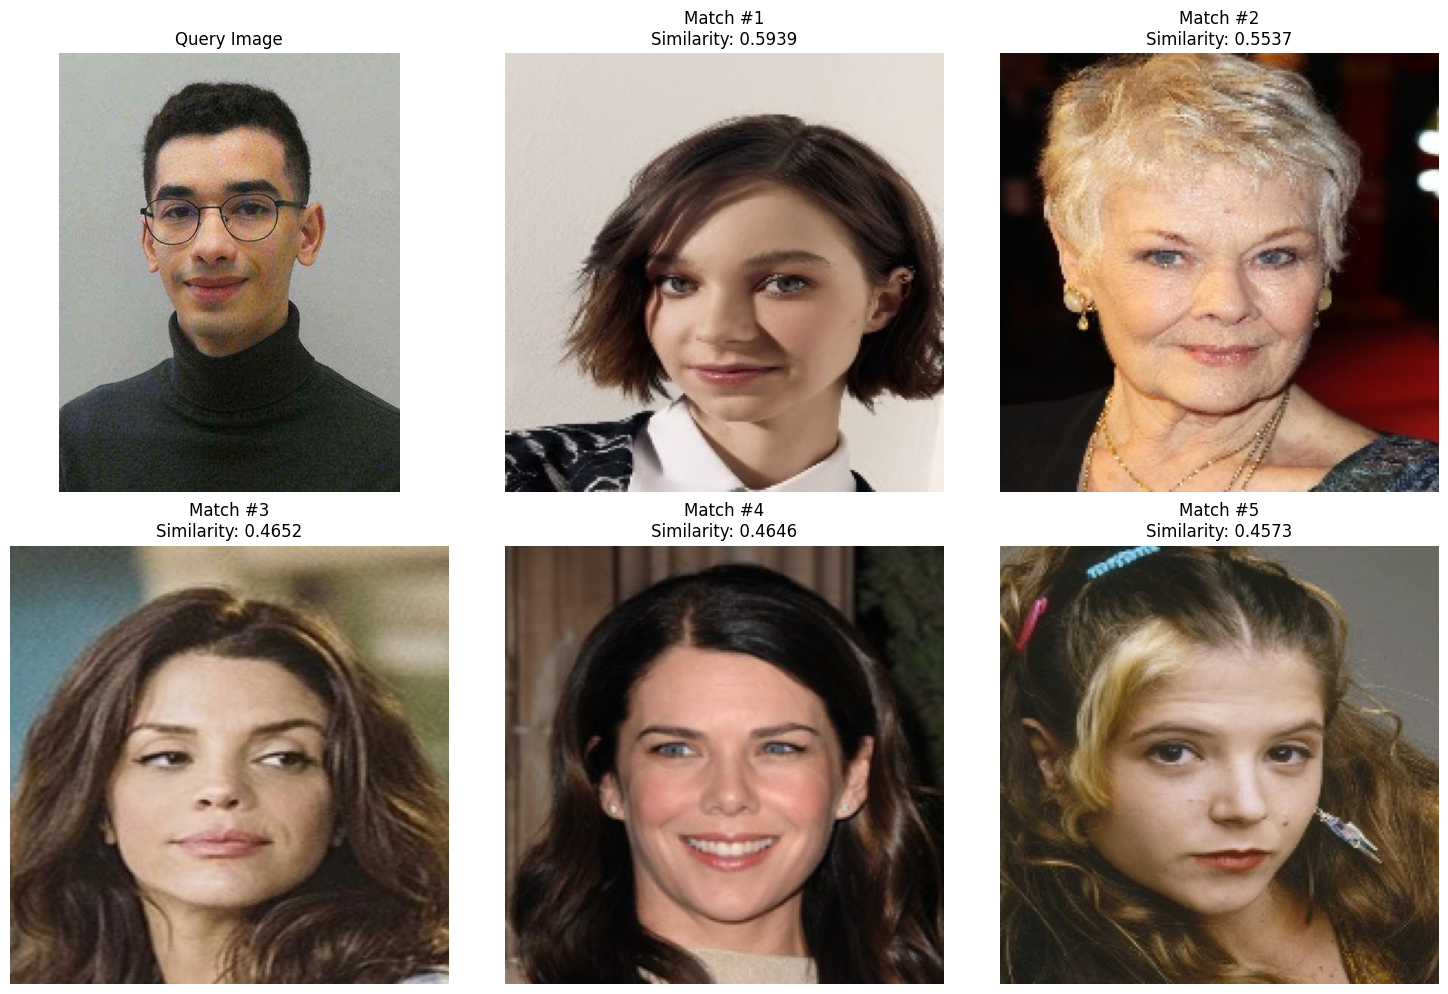

In [53]:
import glob
from matplotlib import pyplot as plt

# Get all image filenames
all_celeb_filenames = glob.glob(os.path.join(dataFolder, '*.jpg'))
all_celeb_filenames = sorted(all_celeb_filenames)

# Get the filenames for the top 5 matches using the indices
# These indices correspond to the sorted order in the celebrity embeddings
top_indices = sorted_indices[:5]

# Map indices back to original file indices
top_files = [all_celeb_filenames[loaded_indices[idx]] if idx < len(loaded_indices) else None for idx in top_indices]

# Display the results
plt.figure(figsize=(15, 10))

# Display query image
plt.subplot(2, 3, 1)
plt.imshow(queryImg.permute(1, 2, 0).numpy())
plt.title("Query Image")
plt.axis('off')

# Display the top 5 matches
for i, file_path in enumerate(top_files):
    if file_path and os.path.exists(file_path):
        plt.subplot(2, 3, i+2)
        img = loadImage(file_path)
        plt.imshow(img.permute(1, 2, 0).numpy())
        plt.title(f"Match #{i+1}\nSimilarity: {sorted_similarities[i]:.4f}")
        plt.axis('off')
    else:
        print(f"Warning: File at index {top_indices[i]} not found")

plt.tight_layout()
plt.show()

# 4) Going Further

A few ideas:
- Query image & database preprocessing
- Try different metrics
- Use several clustering algorithms

In [67]:
# Additional methods for more sophisticated celebrity matching
# Different similarity metrics comparison
def compare_metrics(allCelebrityEmbeddings, queryEmbeddingBatch):
    """
    Compute different similarity/distance metrics and return as tensor
    """
    # Ensure inputs are in correct format
    query_embedding = queryEmbeddingBatch[0].cpu().numpy().reshape(1, -1)
    celeb_embeddings = allCelebrityEmbeddings.cpu().numpy()

    results = {}

    # Cosine similarity
    from sklearn.metrics.pairwise import cosine_similarity
    cosine_sim = cosine_similarity(celeb_embeddings, query_embedding).flatten()
    results['cosine'] = torch.tensor(cosine_sim, dtype=torch.float32)

    # Euclidean distance (converted to similarity by negating)
    from sklearn.metrics.pairwise import euclidean_distances
    euclidean_dist = euclidean_distances(celeb_embeddings, query_embedding).flatten()
    # Convert distance to similarity (higher is better)
    euclidean_sim = -euclidean_dist  # Negate so higher is better
    results['euclidean'] = torch.tensor(euclidean_sim, dtype=torch.float32)

    # Manhattan distance (converted to similarity by negating)
    from sklearn.metrics.pairwise import manhattan_distances
    manhattan_dist = manhattan_distances(celeb_embeddings, query_embedding).flatten()
    # Convert distance to similarity (higher is better)
    manhattan_sim = -manhattan_dist  # Negate so higher is better
    results['manhattan'] = torch.tensor(manhattan_sim, dtype=torch.float32)

    return results

# Using clustering to find similar celebrities
def cluster_celebrities(n_clusters=10):
    from sklearn.cluster import KMeans

    # Apply KMeans clustering to celebrity embeddings
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(allCelebrityEmbeddings.numpy())

    # Find the cluster of the query image
    query_cluster = kmeans.predict(queryEmbeddingBatch[0].numpy().reshape(1, -1))[0]

    # Get celebrities in the same cluster
    cluster_members = [i for i, label in enumerate(cluster_labels) if label == query_cluster]

    return cluster_members, cluster_labels

In [68]:
metrics_comparison = compare_metrics(allCelebrityEmbeddings, queryEmbeddingBatch)
cluster_members, all_clusters = cluster_celebrities(n_clusters=20)

In [75]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from scipy.stats import spearmanr

def analyze_metrics_and_clusters(metrics_comparison, cluster_members, all_clusters,
                                queryEmbeddingBatch, allCelebrityEmbeddings,
                                top_n=10, all_celeb_filenames=None, loaded_indices=None, backbone=None):
    """
    Analyze and visualize different similarity metrics and clustering results

    Args:
        metrics_comparison: Dictionary of different metrics (from compare_metrics)
        cluster_members: List of indices of celebrities in the same cluster as query
        all_clusters: Array of cluster assignments for all celebrities
        queryEmbeddingBatch: Query embedding tensor
        allCelebrityEmbeddings: Celebrity embeddings tensor
        top_n: Number of top matches to analyze
        all_celeb_filenames: List of all celebrity filenames
        loaded_indices: List of valid indices from the embedding creation
    """

    # Check if queryEmbeddingBatch is an image and convert to embedding if needed
    if len(queryEmbeddingBatch.shape) == 4:  # It's an image with shape [batch, channels, height, width]
        if backbone is None:
            raise ValueError("backbone model is required when passing an image as queryEmbeddingBatch")

        # Extract embedding
        with torch.no_grad():
            backbone.eval()
            query_embedding = backbone(queryEmbeddingBatch.to(device)).cpu()
    else:
        # It's already an embedding
        query_embedding = queryEmbeddingBatch

    # Store the original query image for display purposes
    query_image = queryEmbeddingBatch if len(queryEmbeddingBatch.shape) == 4 else None

    # Convert arrays to appropriate types
    if isinstance(all_clusters, list):
        all_clusters = np.array(all_clusters)

    # Part 1: Metrics Analysis
    print("\n=== METRICS ANALYSIS ===")

    # 1.1 Compare top matches across metrics
    metric_names = list(metrics_comparison.keys())
    fig, axes = plt.subplots(len(metric_names), 1, figsize=(12, 4*len(metric_names)))

    # Ensure axes is always indexable as an array
    if len(metric_names) == 1:
        axes = np.array([axes])

    top_indices_by_metric = {}
    for i, (metric_name, values) in enumerate(metrics_comparison.items()):
        # Convert to PyTorch tensor if it's not already
        if not isinstance(values, torch.Tensor):
            values = torch.tensor(values, dtype=torch.float32)

        # Get top indices for this metric
        sorted_values, sorted_indices = torch.sort(values, descending=True)
        top_indices = sorted_indices[:top_n].cpu().numpy()
        top_indices_by_metric[metric_name] = top_indices

        # Plot top matches
        plot_values = sorted_values[:top_n].cpu().numpy()
        axes[i].bar(range(top_n), plot_values)
        axes[i].set_title(f"Top {top_n} Matches using {metric_name.capitalize()} Similarity")
        axes[i].set_xlabel("Rank")
        axes[i].set_ylabel("Similarity Score")
        axes[i].set_xticks(range(top_n))
        axes[i].set_xticklabels([f"#{j+1}" for j in range(top_n)])

    plt.tight_layout()
    plt.show()

    # 1.2 Correlation between metrics
    print("\nCorrelation between different metrics:")
    correlation_matrix = np.zeros((len(metric_names), len(metric_names)))
    for i, metric1 in enumerate(metric_names):
        for j, metric2 in enumerate(metric_names):
            # Ensure we have numpy arrays for correlation calculation
            values1 = metrics_comparison[metric1].cpu().numpy() if isinstance(metrics_comparison[metric1], torch.Tensor) else metrics_comparison[metric1]
            values2 = metrics_comparison[metric2].cpu().numpy() if isinstance(metrics_comparison[metric2], torch.Tensor) else metrics_comparison[metric2]

            # Calculate Spearman rank correlation
            from scipy.stats import spearmanr
            correlation, _ = spearmanr(values1, values2)
            correlation_matrix[i, j] = correlation

    # Visualize correlation matrix
    plt.figure(figsize=(8, 6))
    import seaborn as sns
    sns.heatmap(correlation_matrix, annot=True, xticklabels=metric_names,
                yticklabels=metric_names, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title("Correlation Between Different Similarity Metrics")
    plt.tight_layout()
    plt.show()

    # 1.3 Agreement in top matches
    print("\nAgreement in top matches across metrics:")
    match_counts = {}
    for indices in top_indices_by_metric.values():
        for idx in indices:
            if idx not in match_counts:
                match_counts[idx] = 0
            match_counts[idx] += 1

    # Find celebrities that appear in multiple top-N lists
    consensus_matches = {k: v for k, v in match_counts.items() if v > 1}
    print(f"Found {len(consensus_matches)} celebrities that appear in multiple top-{top_n} lists")

    # Display top consensus matches
    if consensus_matches and all_celeb_filenames and loaded_indices:
        consensus_indices = sorted(consensus_matches.keys(),
                                  key=lambda x: consensus_matches[x],
                                  reverse=True)[:5]

        plt.figure(figsize=(15, 6))
        plt.subplot(1, 6, 1)
        plt.imshow((queryEmbeddingBatch[0].permute(1, 2, 0).numpy() + 1) * 0.5)
        plt.title("Query Image")
        plt.axis('off')

        for i, idx in enumerate(consensus_indices[:5]):
            plt.subplot(1, 6, i+2)
            # Map back to original index
            orig_idx = loaded_indices[idx] if idx < len(loaded_indices) else None
            if orig_idx is not None and orig_idx < len(all_celeb_filenames):
                img = loadImage(all_celeb_filenames[orig_idx])
                plt.imshow(img.permute(1, 2, 0).numpy())
                plt.title(f"Match in {consensus_matches[idx]}/{len(metric_names)} metrics")
                plt.axis('off')

        plt.tight_layout()
        plt.show()

    # Part 2: Cluster Analysis
    print("\n=== CLUSTER ANALYSIS ===")

    # 2.1 Cluster distribution
    unique_clusters, cluster_counts = np.unique(all_clusters, return_counts=True)

    plt.figure(figsize=(12, 5))
    plt.bar(unique_clusters, cluster_counts)
    plt.axvline(x=all_clusters[cluster_members[0]], color='red', linestyle='--',
               label=f"Query Cluster ({all_clusters[cluster_members[0]]})")
    plt.xlabel("Cluster ID")
    plt.ylabel("Number of Celebrities")
    plt.title("Distribution of Celebrities Across Clusters")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 2.2 Dimensionality reduction for visualization
    # Sample if there are too many embeddings (for speed)
    max_samples = 1000
    if len(allCelebrityEmbeddings) > max_samples:
        indices = np.random.choice(len(allCelebrityEmbeddings), max_samples, replace=False)
        sampled_embeddings = allCelebrityEmbeddings[indices]
        sampled_clusters = all_clusters[indices]
        # Check if query cluster is included in sample
        query_cluster = all_clusters[cluster_members[0]]
        if query_cluster not in sampled_clusters:
            # Add some samples from query cluster
            query_samples = np.random.choice(cluster_members, min(20, len(cluster_members)), replace=False)
            sampled_embeddings = torch.cat([sampled_embeddings, allCelebrityEmbeddings[query_samples]])
            sampled_clusters = np.append(sampled_clusters, all_clusters[query_samples])
    else:
        sampled_embeddings = allCelebrityEmbeddings
        sampled_clusters = all_clusters

    # Add query embedding - using the extracted embedding, not the image
    all_embeddings = torch.cat([sampled_embeddings, query_embedding])
    all_cluster_labels = np.append(sampled_clusters, -1)  # -1 for query

    # Compute t-SNE
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    tsne_result = tsne.fit_transform(all_embeddings.numpy())

    # Visualize t-SNE
    plt.figure(figsize=(12, 10))

    # Plot all clusters
    unique_clusters = np.unique(sampled_clusters)
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_clusters)))

    for i, cluster_id in enumerate(unique_clusters):
        cluster_points = tsne_result[all_cluster_labels == cluster_id]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1],
                   color=colors[i], alpha=0.6, label=f"Cluster {cluster_id}")

    # Highlight query cluster
    query_cluster = all_clusters[cluster_members[0]]
    query_cluster_points = tsne_result[all_cluster_labels == query_cluster]
    plt.scatter(query_cluster_points[:, 0], query_cluster_points[:, 1],
               color=colors[np.where(unique_clusters == query_cluster)[0][0]],
               alpha=0.9, s=100, edgecolors='black', linewidths=1)

    # Plot query point
    query_point = tsne_result[-1]
    plt.scatter(query_point[0], query_point[1], color='red', s=200, marker='*',
               label='Query Image', edgecolors='black', linewidths=1, zorder=10)

    plt.title("t-SNE Visualization of Celebrity Embeddings with Clusters")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # 2.3 Analyze query cluster
    print(f"\nQuery is in cluster {query_cluster} with {len(cluster_members)} other celebrities")

    # Compute average similarity within the cluster
    cluster_embeddings = allCelebrityEmbeddings[cluster_members]
    similarities = []
    for emb in cluster_embeddings:
        # Use query_embedding here, not queryEmbeddingBatch
        sim = torch.nn.functional.cosine_similarity(
            emb.unsqueeze(0), query_embedding, dim=1)
        similarities.append(sim.item())

    avg_similarity = np.mean(similarities)
    print(f"Average similarity to query within cluster: {avg_similarity:.4f}")

    # Show top matches from the same cluster
    if all_celeb_filenames and loaded_indices:
        # Sort cluster members by similarity to query
        sorted_members = [m for _, m in sorted(zip(similarities, cluster_members), reverse=True)]

        # Display top 5 from the cluster
        plt.figure(figsize=(15, 6))
        plt.subplot(1, 6, 1)

        # Use the appropriate tensor for display
        if query_image is not None:
            # Display the original image
            plt.imshow((query_image[0].permute(1, 2, 0).cpu().numpy() + 1) * 0.5)
        else:
            # Just show a placeholder if we only have the embedding
            plt.text(0.5, 0.5, "Query\nEmbedding",
                    horizontalalignment='center', verticalalignment='center')
            plt.axis('off')

        plt.title("Query Image")
        plt.axis('off')

        for i, idx in enumerate(sorted_members[:5]):
            plt.subplot(1, 6, i+2)
            # Map back to original index
            orig_idx = loaded_indices[idx] if idx < len(loaded_indices) else None
            if orig_idx is not None and orig_idx < len(all_celeb_filenames):
                img = loadImage(all_celeb_filenames[orig_idx])
                plt.imshow(img.permute(1, 2, 0).numpy())
                plt.title(f"Cluster Match #{i+1}\nSimilarity: {similarities[i]:.4f}")
                plt.axis('off')

        plt.tight_layout()
        plt.show()

    return {
        'consensus_matches': consensus_matches,
        'query_cluster': query_cluster,
        'cluster_members': cluster_members,
        'tsne_result': tsne_result,
        'all_cluster_labels': all_cluster_labels
    }


=== METRICS ANALYSIS ===


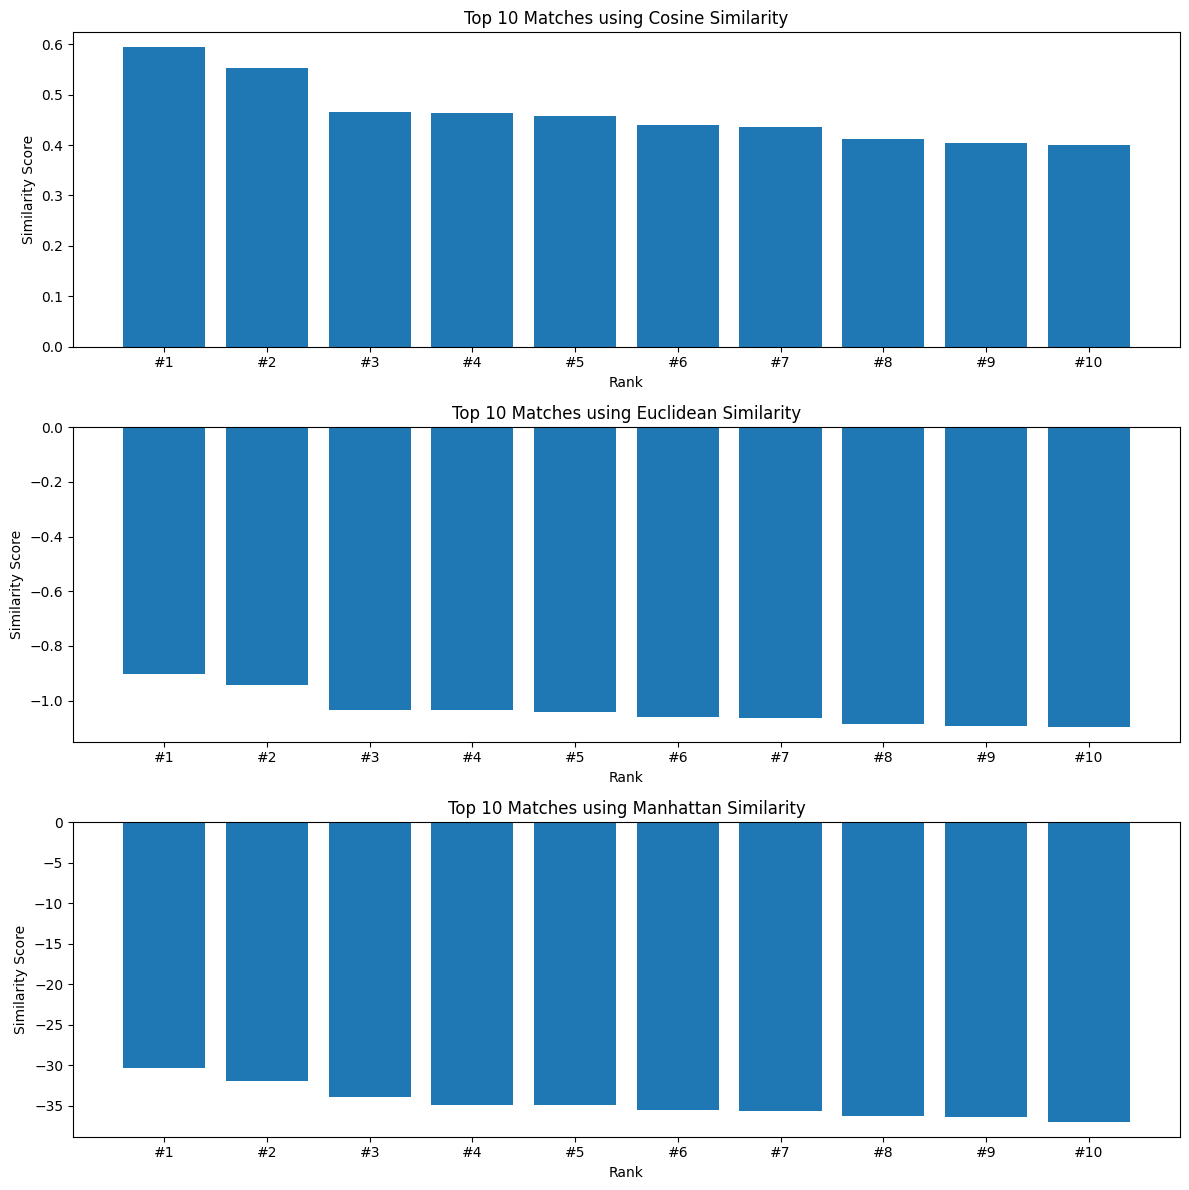


Correlation between different metrics:


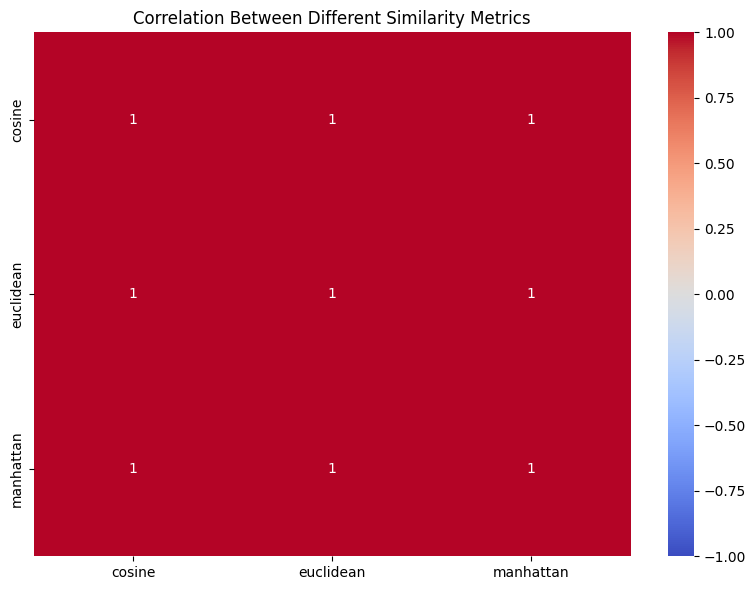


Agreement in top matches across metrics:
Found 10 celebrities that appear in multiple top-10 lists


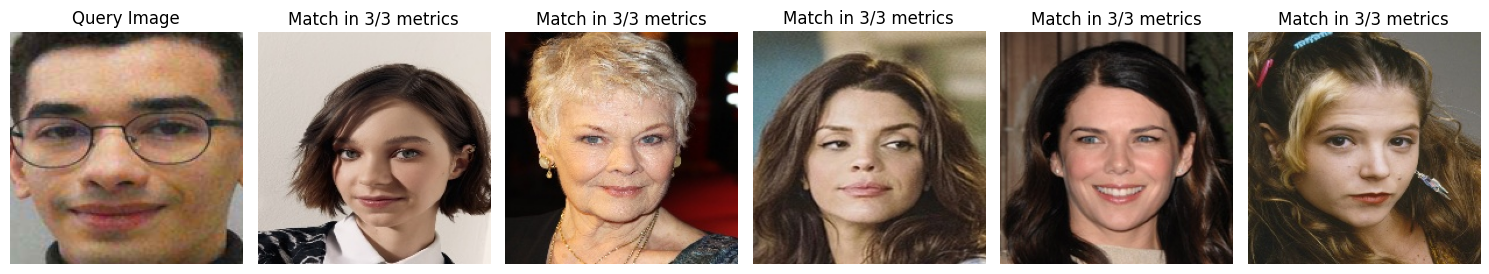


=== CLUSTER ANALYSIS ===


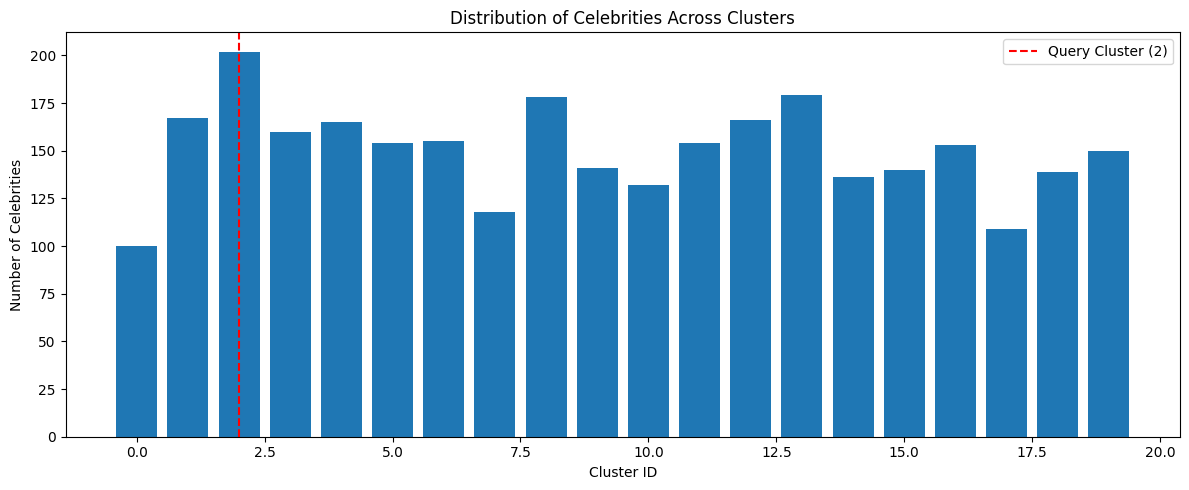

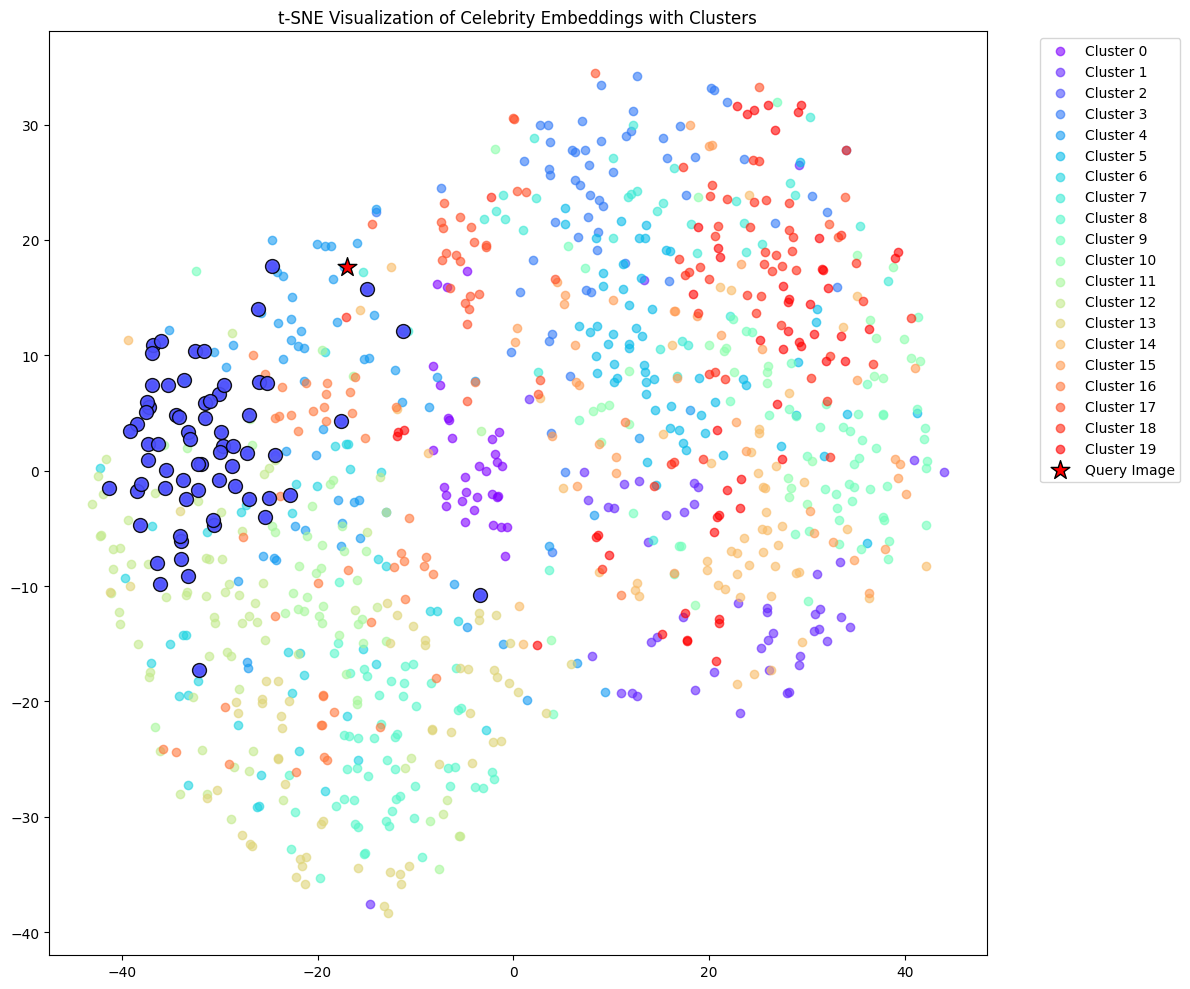


Query is in cluster 2 with 202 other celebrities
Average similarity to query within cluster: 0.0850


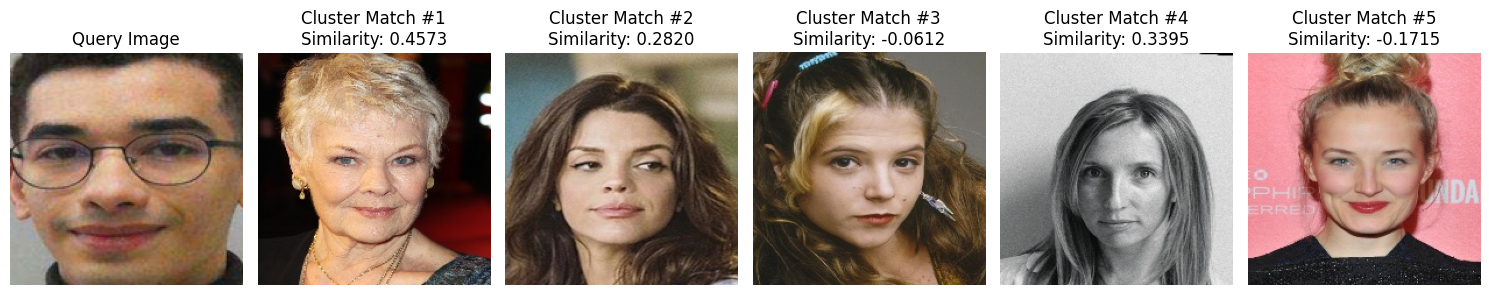

In [76]:
# Get all celebrity filenames
all_celeb_filenames = glob.glob(os.path.join(dataFolder, '*.jpg'))
all_celeb_filenames = sorted(all_celeb_filenames)

# Run analysis
analysis_results = analyze_metrics_and_clusters(
    metrics_comparison=metrics_comparison,
    cluster_members=cluster_members,
    all_clusters=all_clusters,
    queryEmbeddingBatch=croppedQueryImg,  # Use the cropped query face
    allCelebrityEmbeddings=allCelebrityEmbeddings,
    all_celeb_filenames=all_celeb_filenames,
    loaded_indices=loaded_indices,
    backbone=backbone
)

I didn't know I was a woman! (note this is an old photo of young Elias with no beard)